# Projekt 2 
### P. Fijałkowski, M. Krzyziński, T. Nocoń

## Inżynieria cech, wstępne modelowanie 

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.manifold import TSNE

from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier, plot_importance
from sklearn.metrics import classification_report, roc_auc_score

import warnings
warnings.filterwarnings('ignore')

In [30]:
online_shopping = pd.read_csv("online_shoppers_intention.csv")
data = online_shopping.copy() # robimy zmiany na tej ramce, a orginału nie ruszamy

In [31]:
data

Administrative  Administrative_Duration  Informational  \
0                   0                      0.0              0   
1                   0                      0.0              0   
2                   0                      0.0              0   
3                   0                      0.0              0   
4                   0                      0.0              0   
...               ...                      ...            ...   
12325               3                    145.0              0   
12326               0                      0.0              0   
12327               0                      0.0              0   
12328               4                     75.0              0   
12329               0                      0.0              0   

       Informational_Duration  ProductRelated  ProductRelated_Duration  \
0                         0.0               1                 0.000000   
1                         0.0               2                64.000000   
2                         0.0               1                 0.000000   
3                         0.0               2                 2.666667   
4                         0.0              10               627.500000   
...                       ...             ...                      ...   
12325                     0.0              53              1783.791667   
12326                     0.0               5               465.750000   
12327                     0.0               6               184.250000   
12328                     0.0              15               346.000000   
12329                     0.0               3                21.250000   

       BounceRates  ExitRates  PageValues  SpecialDay Month  OperatingSystems  \
0         0.200000   0.200000    0.000000         0.0   Feb                 1   
1         0.000000   0.100000    0.000000         0.0   Feb                 2   
2         0.200000   0.200000    0.000000         0.0   Feb                 4   
3         0.050000   0.140000    0.000000         0.0   Feb                 3   
4         0.020000   0.050000    0.000000         0.0   Feb                 3   
...            ...        ...         ...         ...   ...               ...   
12325     0.007143   0.029031   12.241717         0.0   Dec                 4   
12326     0.000000   0.021333    0.000000         0.0   Nov                 3   
12327     0.083333   0.086667    0.000000         0.0   Nov                 3   
12328     0.000000   0.021053    0.000000         0.0   Nov                 2   
12329     0.000000   0.066667    0.000000         0.0   Nov                 3   

       Browser  Region  TrafficType        VisitorType  Weekend  Revenue  
0            1       1            1  Returning_Visitor    False    False  
1            2       1            2  Returning_Visitor    False    False  
2            1       9            3  Returning_Visitor    False    False  
3            2       2            4  Returning_Visitor    False    False  
4            3       1            4  Returning_Visitor     True    False  
...        ...     ...          ...                ...      ...      ...  
12325        6       1            1  Returning_Visitor     True    False  
12326        2       1            8  Returning_Visitor     True    False  
12327        2       1           13  Returning_Visitor     True    False  
12328        2       3           11  Returning_Visitor    False    False  
12329        2       1            2        New_Visitor     True    False  

[12330 rows x 18 columns]

Tak jak ustaliliśmy przy poprzedniej części projektu, dla problemu klasteryzacji przed przejściem do jakichkolwiek czynności grupujących, należy znormalizować/przeskalować zmienne. Ponadto należy zająć się zmiennymymi typu kategorycznego (które w naszym przypadku są już w większości zakodowane w sposób liczbowy). Zastosujemy kilka podejść, by w dalszych etapach badać, które z nich będzie najlepsze.


### Zmiana wszystkich zmiennych na format liczbowy
Zanim przejdziemy do różnych skalowań, przeprowadźmy ogólny krok w preprocessingu: zamieńmy wszystkie dane w ramce na liczbowe - w tym celu konieczne jest zakodowanie nazw miesięcy (kolumn `Month`), typu odwiedzającego stronę (`VisitorType`) i informacji o tym, czy dana sesja odbyła się w weekend (`Weekend`) oraz czy przyniosła dochód (`Revenue`). 

#### Month

In [33]:
months = ["Jan", "Feb", "Mar", "Apr", "May", "June", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"] 
months_dict = {k: v+1 for v, k in enumerate(months)}
months_dict

{'Jan': 1,
 'Feb': 2,
 'Mar': 3,
 'Apr': 4,
 'May': 5,
 'June': 6,
 'Jul': 7,
 'Aug': 8,
 'Sep': 9,
 'Oct': 10,
 'Nov': 11,
 'Dec': 12}

In [34]:
old_months = data["Month"] # dla porównania
data["Month"] = data["Month"].map(months_dict)

In [271]:
pd.concat([data["Month"], old_months], axis=1).drop_duplicates() # jest ok

Month Month
0        2   Feb
184      3   Mar
2091     5   May
5455    10   Oct
5456     6  June
5460     7   Jul
5462     8   Aug
5463    11   Nov
5468     9   Sep
7982    12   Dec

#### VisitorType

In [35]:
from sklearn.preprocessing import OrdinalEncoder
ord_enc_visitor_type = OrdinalEncoder()
data["VisitorType"] = ord_enc_visitor_type.fit_transform(data["VisitorType"].values.reshape(-1, 1))

In [273]:
ord_enc_visitor_type.categories_

[array(['New_Visitor', 'Other', 'Returning_Visitor'], dtype=object)]

#### Weekend,  Revenue

In [36]:
booleans = ['Weekend', 'Revenue']
for boolean in booleans:
    data[boolean] = data[boolean].transform(lambda val: 1 if val else 0)

#### Wynik

In [37]:
print(f"""Liczba kolumn numerycznych: {len(data.select_dtypes('number').columns)}
Liczba wszystkich kolumn: {len(data.columns)}""")

Liczba kolumn numerycznych: 18
Liczba wszystkich kolumn: 18


In [276]:
data

Administrative  Administrative_Duration  Informational  \
0                   0                      0.0              0   
1                   0                      0.0              0   
2                   0                      0.0              0   
3                   0                      0.0              0   
4                   0                      0.0              0   
...               ...                      ...            ...   
12325               3                    145.0              0   
12326               0                      0.0              0   
12327               0                      0.0              0   
12328               4                     75.0              0   
12329               0                      0.0              0   

       Informational_Duration  ProductRelated  ProductRelated_Duration  \
0                         0.0               1                 0.000000   
1                         0.0               2                64.000000   
2                         0.0               1                 0.000000   
3                         0.0               2                 2.666667   
4                         0.0              10               627.500000   
...                       ...             ...                      ...   
12325                     0.0              53              1783.791667   
12326                     0.0               5               465.750000   
12327                     0.0               6               184.250000   
12328                     0.0              15               346.000000   
12329                     0.0               3                21.250000   

       BounceRates  ExitRates  PageValues  SpecialDay  Month  \
0         0.200000   0.200000    0.000000         0.0      2   
1         0.000000   0.100000    0.000000         0.0      2   
2         0.200000   0.200000    0.000000         0.0      2   
3         0.050000   0.140000    0.000000         0.0      2   
4         0.020000   0.050000    0.000000         0.0      2   
...            ...        ...         ...         ...    ...   
12325     0.007143   0.029031   12.241717         0.0     12   
12326     0.000000   0.021333    0.000000         0.0     11   
12327     0.083333   0.086667    0.000000         0.0     11   
12328     0.000000   0.021053    0.000000         0.0     11   
12329     0.000000   0.066667    0.000000         0.0     11   

       OperatingSystems  Browser  Region  TrafficType  VisitorType  Weekend  \
0                     1        1       1            1          2.0        0   
1                     2        2       1            2          2.0        0   
2                     4        1       9            3          2.0        0   
3                     3        2       2            4          2.0        0   
4                     3        3       1            4          2.0        1   
...                 ...      ...     ...          ...          ...      ...   
12325                 4        6       1            1          2.0        1   
12326                 3        2       1            8          2.0        1   
12327                 3        2       1           13          2.0        1   
12328                 2        2       3           11          2.0        0   
12329                 3        2       1            2          0.0        1   

       Revenue  
0            0  
1            0  
2            0  
3            0  
4            0  
...        ...  
12325        0  
12326        0  
12327        0  
12328        0  
12329        0  

[12330 rows x 18 columns]

Teraz możemy już przejść do różnych wariantów skalowania i kodowania zmiennych.

### Wariant 1 
Możemy uznać go za bazowy, wręcz prymitywny. W tym przypadku postąpimy bowiem bardzo prosto. Mając wszystkie zmienne w formie liczbowej, bez większego namysłu zastosujemy standardyzację. 

In [15]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data)
data_m1 = pd.DataFrame(scaled_data, columns = data.columns)

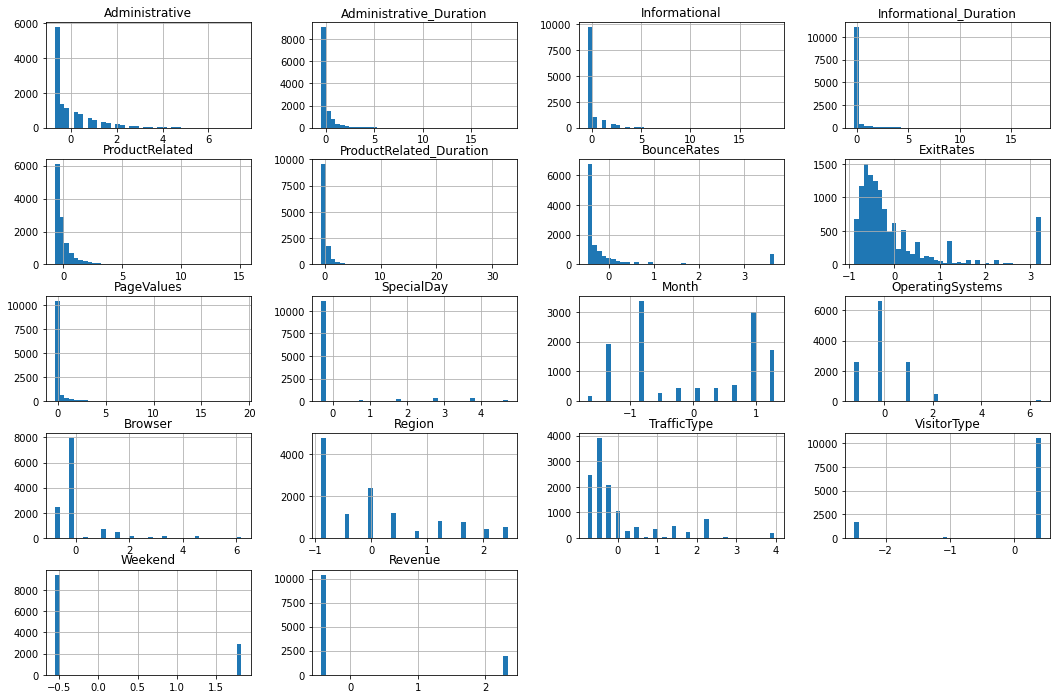

In [16]:
pd.DataFrame(data_m1).hist(bins = 40, figsize=(18, 12))
plt.show()

Jak widać zmienne zostały ustandaryzowane, ale zachowały kształty rozkładów, które widzieliśmy już w EDA. Widząc skośność niektórych zmiennych, można pomyśleć o transformacji logarytmicznej, by rozkłady były bardziej podobne do gaussowskich.

Aby zwizualizować wielowymiarowe dane po kolejnych przekształceniach wykorzystamy metodę redukcji wielowymiarowości t-SNE. 

In [105]:
from sklearn.manifold import TSNE
tSNE = TSNE(learning_rate = 400, random_state = 42, verbose = 1)

In [106]:
proj_tSNE_data1 = tSNE.fit_transform(data_m1)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 12330 samples in 0.001s...
[t-SNE] Computed neighbors for 12330 samples in 5.632s...
[t-SNE] Computed conditional probabilities for sample 1000 / 12330
[t-SNE] Computed conditional probabilities for sample 2000 / 12330
[t-SNE] Computed conditional probabilities for sample 3000 / 12330
[t-SNE] Computed conditional probabilities for sample 4000 / 12330
[t-SNE] Computed conditional probabilities for sample 5000 / 12330
[t-SNE] Computed conditional probabilities for sample 6000 / 12330
[t-SNE] Computed conditional probabilities for sample 7000 / 12330
[t-SNE] Computed conditional probabilities for sample 8000 / 12330
[t-SNE] Computed conditional probabilities for sample 9000 / 12330
[t-SNE] Computed conditional probabilities for sample 10000 / 12330
[t-SNE] Computed conditional probabilities for sample 11000 / 12330
[t-SNE] Computed conditional probabilities for sample 12000 / 12330
[t-SNE] Computed conditional probabilities for sam

In [113]:
data_m1["tsne_1"] = proj_tSNE_data1[:, 0]
data_m1["tsne_2"] = proj_tSNE_data1[:, 1]

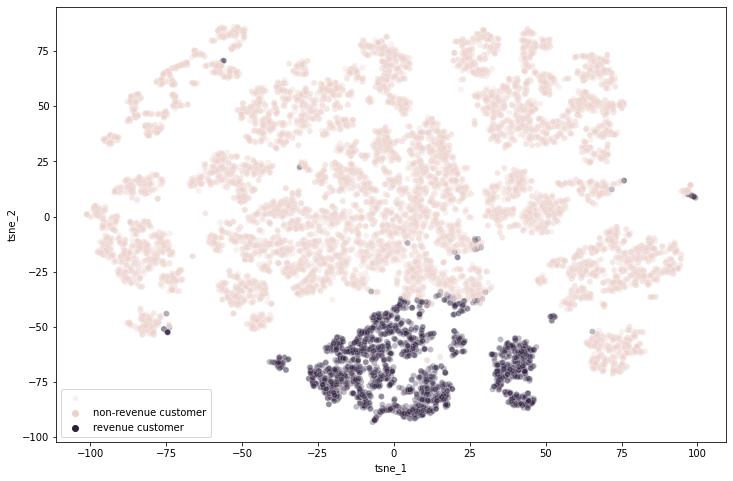

In [127]:
plt.figure(figsize=(12,8))
sns.scatterplot(x = "tsne_1",
                y = "tsne_2", 
                hue = "Revenue",
                alpha=0.3,
                data = data_m1)
plt.legend(labels=['', 'non-revenue customer', 'revenue customer'])
plt.show()

Widzimy, że taki zestaw danych zwizualizowany poprzez tSNE daje nam już całkiem ciekawy rezultat. Widzimy, że klienci ze względu na generowanie dochodu zostali odseparowani i w tych grupach również możemy wyróżnić kilka podgrup. Ale spróbjmy bardziej wyrafinowanych metod inżynierii danych. 

### Wariant 2 
Tym razem przed standardyzacją wykonamy transformację logarytmiczną zmiennych o skośnych rozkładach. 

In [277]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
log_features = ['Administrative', 'Administrative_Duration', 'Informational',
                'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration',
                'BounceRates', 'ExitRates', 'PageValues']
transformer = ColumnTransformer(
    [ ('log', FunctionTransformer(np.log1p), log_features) ],
    remainder = 'passthrough'
)
transformed_data = transformer.fit_transform(data)
scaled_data = scaler.fit_transform(transformed_data)

data_m2 = pd.DataFrame(scaled_data, columns = data.columns)

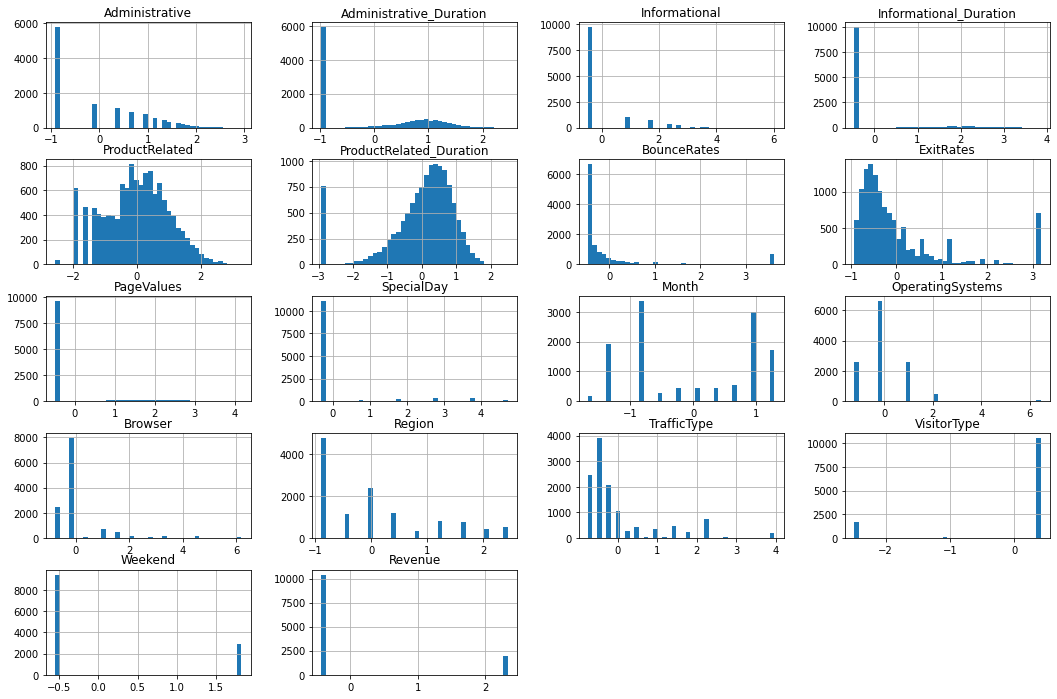

In [278]:
pd.DataFrame(data_m2).hist(bins = 40, figsize=(18, 12))
plt.show()

Zobaczmy, co teraz zwizualizuje nam tSNE. 

In [134]:
proj_tSNE_data2 = tSNE.fit_transform(data_m2)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 12330 samples in 0.001s...
[t-SNE] Computed neighbors for 12330 samples in 6.142s...
[t-SNE] Computed conditional probabilities for sample 1000 / 12330
[t-SNE] Computed conditional probabilities for sample 2000 / 12330
[t-SNE] Computed conditional probabilities for sample 3000 / 12330
[t-SNE] Computed conditional probabilities for sample 4000 / 12330
[t-SNE] Computed conditional probabilities for sample 5000 / 12330
[t-SNE] Computed conditional probabilities for sample 6000 / 12330
[t-SNE] Computed conditional probabilities for sample 7000 / 12330
[t-SNE] Computed conditional probabilities for sample 8000 / 12330
[t-SNE] Computed conditional probabilities for sample 9000 / 12330
[t-SNE] Computed conditional probabilities for sample 10000 / 12330
[t-SNE] Computed conditional probabilities for sample 11000 / 12330
[t-SNE] Computed conditional probabilities for sample 12000 / 12330
[t-SNE] Computed conditional probabilities for sam

In [135]:
data_m2["tsne_1"] = proj_tSNE_data2[:, 0]
data_m2["tsne_2"] = proj_tSNE_data2[:, 1]

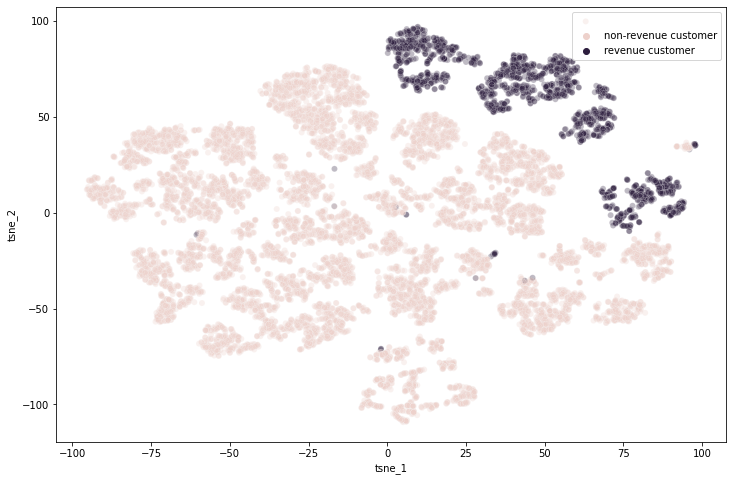

In [140]:
plt.figure(figsize=(12,8))
sns.scatterplot(x = "tsne_1",
                y = "tsne_2", 
                hue = "Revenue",
                alpha=0.3,
                data = data_m2)
plt.legend(labels=['', 'non-revenue customer', 'revenue customer'])
plt.show()

Przy takich samych parametrach algorytmu udało się osiągnąć lepsze (empirycznie) grupowanie. Ale nie poprzestawajmy na tym...

### Wariant 3
Do tej pory skalowaliśmy wszystkie zmienne. Te o naturze kategorycznej traktowaliśmy bowiem jak numeryczne, zakodowane przy pomocy label encodingu. Warto jednak zastanowić się nad zmianą sposobu kodowania i wykorzystać one hot encoding - stworzyć nowe kolumny indykatorowe. 

Jednak one hot encoding każdej unikalnej wartości dla tych zmiennych spowodowałby znaczny wzrost wymiarowości danych. Żeby to zrobić lepiej, zobaczymy najpierw jaki rozkład mają te zmienne.

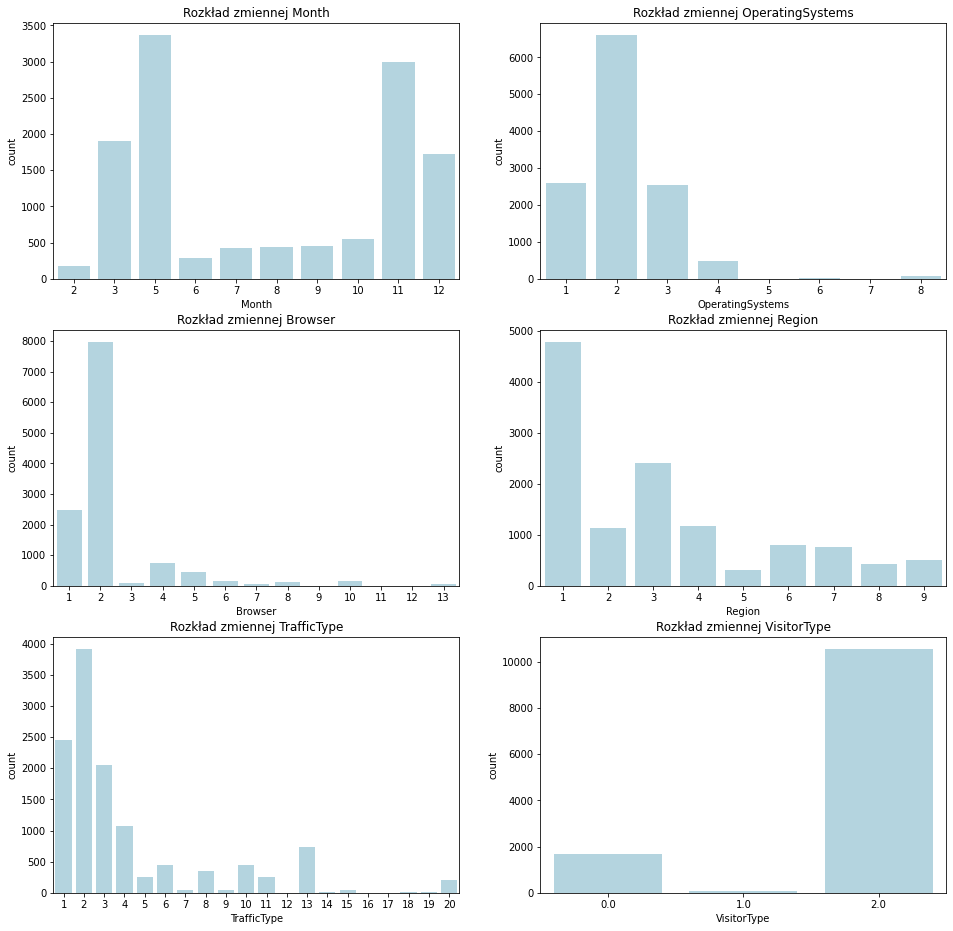

In [312]:
categorical = ['Month', 'OperatingSystems', 'Browser', 'Region', 'TrafficType', 'VisitorType']
fig, axes = plt.subplots(3, 2, figsize=(16, 16))
for i in range(0, len(categorical)):
    sns.countplot(data=data, x=categorical[i], 
                  ax=axes[i//2, i%2], color = "lightblue").set_title(f"Rozkład zmiennej {categorical[i]}")

W przypadku niektórych zmiennych, niewielka liczba kategorii odpowiada za większość wyników. Stąd pomysł, by dla każdej kolumny wziąć pierwsze najbardziej znaczące kategorie, pozostałe natomiast złączyć w jedną. Ponadto miesiące połączymy w kwartały, a zmienną `VisitorType` zakodujemy wprost. 

In [313]:
data_m3 = pd.DataFrame(transformed_data, columns = data.columns)
data_m3.loc[data["Month"].isin([1, 2, 3]), "Quarter"] = 1
data_m3.loc[data["Month"].isin([4, 5, 6]), "Quarter"] = 2
data_m3.loc[data["Month"].isin([7, 8, 9]), "Quarter"] = 3
data_m3.loc[data["Month"].isin([10, 11, 12]), "Quarter"] = 4
data_m3 = data_m3.drop("Month", axis=1)

In [314]:
data_m3 = pd.get_dummies(data_m3, prefix=['Quarter', 'VisitorType'], columns=['Quarter', 'VisitorType'])

In [315]:
def one_hot_encoder(dic, df):
    df_copy = df.copy()
    for m_r in dic.keys():
        most_import = df_copy[m_r].value_counts()[:dic[m_r]].index.tolist()
        df_copy[m_r] = df_copy[m_r].transform(lambda x: x if (x in most_import) else 'others').astype(str)
        encoder = OneHotEncoder(sparse=False, drop=["others"])
        one_hot = pd.DataFrame(encoder.fit_transform(df_copy[[m_r]]))
        one_hot.columns = encoder.get_feature_names([m_r])
        df_copy = pd.concat([df_copy, one_hot], axis=1)
        df_copy = df_copy.drop(m_r, axis=1)
    return df_copy

In [316]:
most_relevant = {"TrafficType" : 5,
                 "Browser" : 2,
                 "OperatingSystems" : 4,
                 "Region" : 4}

data_m3 = one_hot_encoder(most_relevant, data_m3)

Takie zmienne też oczywiście ustandaryzujemy, początkowo wszystkie - łącznie z tymi przed chwilą zakodowanymi. 

In [317]:
scaled_data = scaler.fit_transform(data_m3)
data_m3a = pd.DataFrame(scaled_data, columns = data_m3.columns)

In [318]:
proj_tSNE_data3a = tSNE.fit_transform(data_m3a)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 12330 samples in 0.001s...
[t-SNE] Computed neighbors for 12330 samples in 6.837s...
[t-SNE] Computed conditional probabilities for sample 1000 / 12330
[t-SNE] Computed conditional probabilities for sample 2000 / 12330
[t-SNE] Computed conditional probabilities for sample 3000 / 12330
[t-SNE] Computed conditional probabilities for sample 4000 / 12330
[t-SNE] Computed conditional probabilities for sample 5000 / 12330
[t-SNE] Computed conditional probabilities for sample 6000 / 12330
[t-SNE] Computed conditional probabilities for sample 7000 / 12330
[t-SNE] Computed conditional probabilities for sample 8000 / 12330
[t-SNE] Computed conditional probabilities for sample 9000 / 12330
[t-SNE] Computed conditional probabilities for sample 10000 / 12330
[t-SNE] Computed conditional probabilities for sample 11000 / 12330
[t-SNE] Computed conditional probabilities for sample 12000 / 12330
[t-SNE] Computed conditional probabilities for sam

In [319]:
data_m3a["tsne_1"] = proj_tSNE_data3a[:, 0]
data_m3a["tsne_2"] = proj_tSNE_data3a[:, 1]

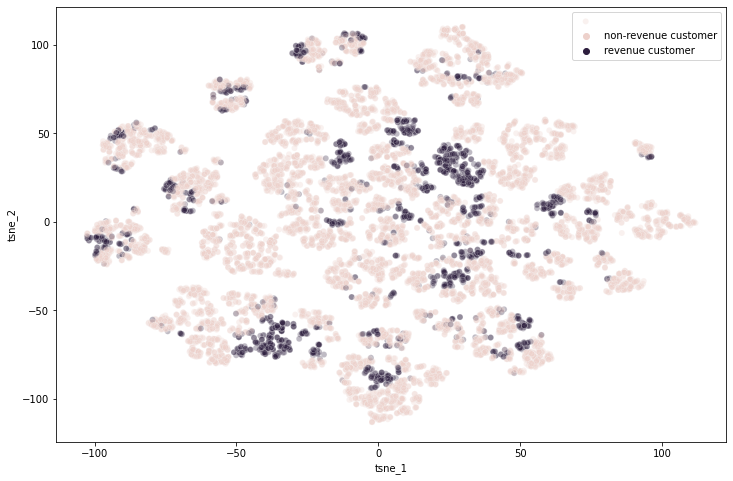

In [320]:
plt.figure(figsize=(12,8))
sns.scatterplot(x = "tsne_1",
                y = "tsne_2", 
                hue = "Revenue",
                alpha=0.3,
                data = data_m3a)
plt.legend(labels=['', 'non-revenue customer', 'revenue customer'])
plt.show()

Niestety w tym przypadku tSNE nie zwizualizował podziału zgodnie z naszymi oczekiwaniami. :(

Spróbujemy jeszcze nie standardyzować zmiennych po one hot encodingu, a tylko wszystkie pozostałe - liczbowe.

In [321]:
num_features = ['Administrative', 'Administrative_Duration', 'Informational',
                'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration',
                'BounceRates', 'ExitRates', 'PageValues', "SpecialDay"]
scaler = ColumnTransformer(
    [ ('log', StandardScaler(), num_features)],
    remainder = 'passthrough'
)
scaled_data = scaler.fit_transform(data_m3)
data_m3b = pd.DataFrame(scaled_data, columns = data_m3.columns)

In [324]:
proj_tSNE_data3b = tSNE.fit_transform(data_m3b)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 12330 samples in 0.001s...
[t-SNE] Computed neighbors for 12330 samples in 5.316s...
[t-SNE] Computed conditional probabilities for sample 1000 / 12330
[t-SNE] Computed conditional probabilities for sample 2000 / 12330
[t-SNE] Computed conditional probabilities for sample 3000 / 12330
[t-SNE] Computed conditional probabilities for sample 4000 / 12330
[t-SNE] Computed conditional probabilities for sample 5000 / 12330
[t-SNE] Computed conditional probabilities for sample 6000 / 12330
[t-SNE] Computed conditional probabilities for sample 7000 / 12330
[t-SNE] Computed conditional probabilities for sample 8000 / 12330
[t-SNE] Computed conditional probabilities for sample 9000 / 12330
[t-SNE] Computed conditional probabilities for sample 10000 / 12330
[t-SNE] Computed conditional probabilities for sample 11000 / 12330
[t-SNE] Computed conditional probabilities for sample 12000 / 12330
[t-SNE] Computed conditional probabilities for sam

In [325]:
data_m3b["tsne_1"] = proj_tSNE_data3b[:, 0]
data_m3b["tsne_2"] = proj_tSNE_data3b[:, 1]

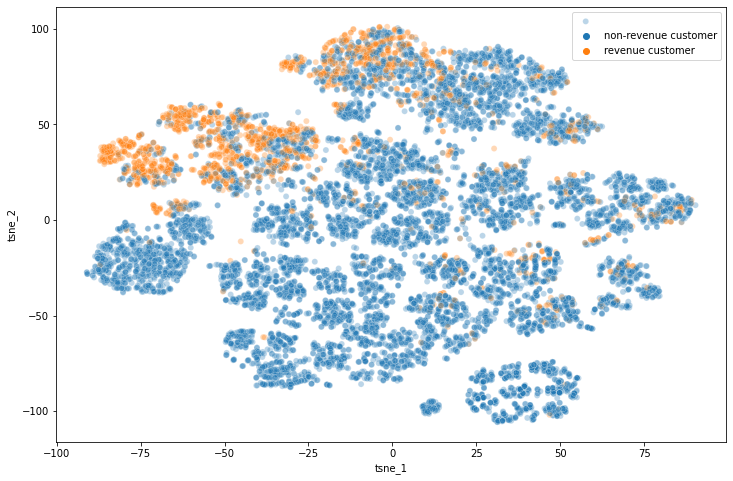

In [326]:
plt.figure(figsize=(12,8))
sns.scatterplot(x = "tsne_1",
                y = "tsne_2", 
                hue = "Revenue",
                alpha=0.3,
                data = data_m3b)
plt.legend(labels=['', 'non-revenue customer', 'revenue customer'])
plt.show()

Teraz wygląda to lepiej, ale wciąż nie jest to oczekiwany rezultat. 

## TO DO 
- zrobienie PCA - sprawdzenie skumulowanej wariancji 
- wstępne modelowanie - to co w PD5, porobić elbow ploty dla KMeans z różnymi wariantami danych powyżej, sprawdzić jak w otrzymanych klastrach przedstawia się procent klientów przynoszących dochód
- napisać wnioski

## Wstępne modelowanie

W tej sekcji przedstawimy najprostszy model algorytmu clusteringu - `KMeans`. Będzie on stanowił punkt wyjścia dla rozważań w dalszych pracach, jako osiągnięty niskim kosztem efekt.

Z racji wielowymiarowości naszych danych (18 kolumn) występuje spora trudność w pierwszym kroku - zakreśleniu obszaru poszukiwań optymalnej ilości klastrów do algorytmu. Przeszukamy więc relatywnie zakres od 4 do 14 klastrów. 

In [22]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score,calinski_harabasz_score

<AxesSubplot:xlabel='cluster_amount'>

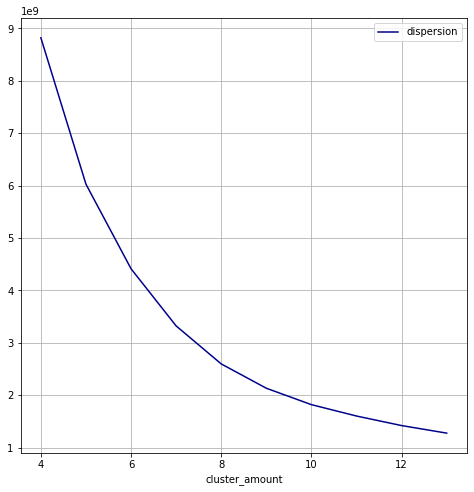

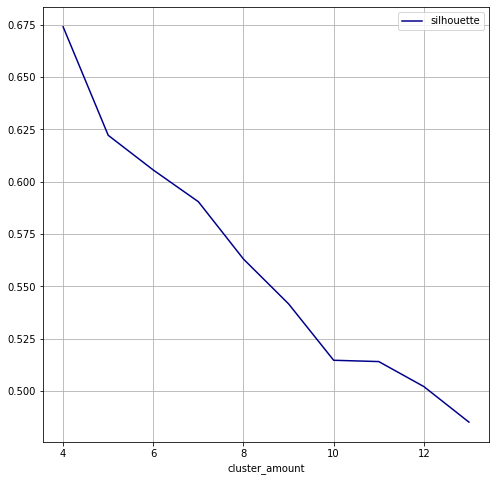

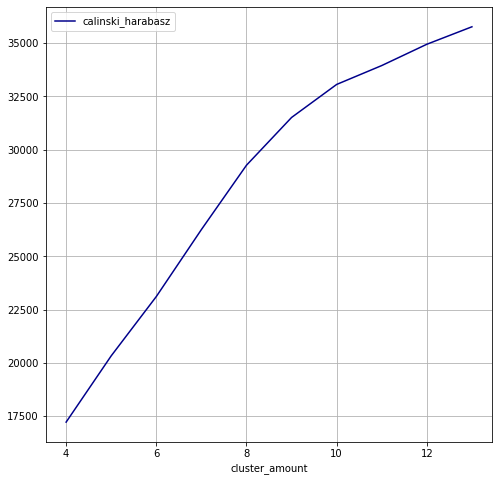

In [25]:
result_dispersion = list()
result_silhouette = list()
result_ch = list()
for cluster_amount in range(4,14):
    my_kmean = KMeans(n_clusters=cluster_amount)
    labels = my_kmean.fit_predict(data)
    result_dispersion.append({"cluster_amount": cluster_amount, "dispersion": my_kmean.inertia_})
    result_silhouette.append({"cluster_amount": cluster_amount, "silhouette": silhouette_score(data,labels)})
    result_ch.append({"cluster_amount": cluster_amount, "calinski_harabasz": calinski_harabasz_score(data, labels)})
pd.DataFrame(result_dispersion, columns=["cluster_amount","dispersion"]).plot.line("cluster_amount", "dispersion", c='DarkBlue', figsize=(8,8), grid=True)
pd.DataFrame(result_silhouette, columns=["cluster_amount","silhouette"]).plot.line("cluster_amount", "silhouette", c='DarkBlue', figsize=(8,8), grid=True)
pd.DataFrame(result_ch, columns=["cluster_amount","calinski_harabasz"]).plot.line("cluster_amount", "calinski_harabasz", c='DarkBlue', figsize=(8,8), grid=True)

Analizując powyższe wykresy możemy stwierdzić, że w naszym przypadku, problem doboru optymalnej ilości klastrów jest bardzo nietrywialny. Z jednej strony "łokieć" wskazujemy w sytuacji 8 klastrów, a z drugiej rosnąca ilość klastrów, pociąga za sobą malejącą wartość metryki `silhouette` (a więc mniejszą poprawność "przydziału" czy spójność wewnątrz klastrową).

Indeks Calińskiego-Harabasza (wykres 3) sugeruje natomiast docelowy wybór 9 klastrów

In [64]:
optimized_kmean = KMeans(n_clusters=9)
labels = optimized_kmean.fit_predict(data)
data['label'] = labels
cluster_sizes = data.groupby('label').size()
revenue_amount = data[['Revenue', 'label']].groupby('label').sum('Revenue')['Revenue']

In [105]:
ratios = [revenue_amount[i]/cluster_sizes[i] for i in range(9)]
combined = zip(range(9), list(cluster_sizes), ratios)
combined = sorted(combined,key=lambda x: x[2],reverse=True)
for i in range(9):
    print(f"CLUSTER {combined[i][0]}: size={combined[i][1]} revenue_ratio={combined[i][2]}")

CLUSTER 6: size=56 revenue_ratio=0.4107142857142857
CLUSTER 1: size=358 revenue_ratio=0.3463687150837989
CLUSTER 8: size=149 revenue_ratio=0.3221476510067114
CLUSTER 3: size=10 revenue_ratio=0.3
CLUSTER 2: size=813 revenue_ratio=0.23124231242312424
CLUSTER 7: size=3196 revenue_ratio=0.20619524405506884
CLUSTER 4: size=1715 revenue_ratio=0.20524781341107873
CLUSTER 0: size=6031 revenue_ratio=0.08472890067982093
CLUSTER 5: size=2 revenue_ratio=0.0


Widzimy więc, że istnieją klastry w których znaczący procent stanowią klienci generujący dochód dla sklepu (przede wszystkim 6, 1, 8, 3). Na dalszym etapie modelowania będziemy starać się wyjaśniać czym charakteryzują się owe klastry i przede wszystkim czym różnią się od obserwacji znajdujących się np. w klastrze 5).

Miejmy również na uwadze rozmiary klastrów (w szczególności przeważający rozmiarem klaster 0).

## Wnioski

Przeprowadzając inżynierię cech, wnioskujemy o nietrywialności rozważanego zagadnienia. Z uwagi na wielowymiarowość problemu (w sensie matematycznym i ludzkim), nie jest łatwym zadaniem jednoznacznie wybrać zestaw przekształceń zmiennych i dobrać rozmiary problemu celem osiągnięcia pożądanego efektu.

Idąc dalej, można podejrzewać, że problem nie ma jednoznacznego "rozwiązania", wiemy przecież jak złożona jest natura ludzka, jak wiele składników może na nią wpływać. W takiej sytuacji jednoznaczna kategoryzacja osób przestaje być możliwa.

W dalszych pracach planujemy ograniczyć ilość zmiennych i zamodelować odpowiadający naszemu problemowi algorytm klasteryzacji, wyjaśniając różnicę pomiędzy charakterystykami obserwacji należących do danego klastra.